## Test sensitivity to the number of ensemble members used as training data

** Note: In the re-submitted manuscript, it was claimed that as few as 5 ensemble members could be used to train the emulator without significantly affecting results. However, upon further testing, it is now clear that 5 members is not sufficient and at least 10 ensemble members are needed. **

In [1]:
import numpy as np, xarray as xr, matplotlib.pylab as plt, pandas as pd, seaborn as sns
import pickle, random, re, io, regionmask, dask, timeit, os, shutil, datetime
from scipy.signal import welch; from eofs.xarray import Eof; import matplotlib as mpl

from statsmodels.tsa.api import VAR; from contextlib import redirect_stdout
from distributed import Client; from scipy import stats
import cartopy.crs as ccrs, cartopy.feature as cfeature
import matplotlib.gridspec as gridspec; import cartopy.feature as cfeature
from matplotlib.colors import Normalize; import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from InVERT_functions import (calc_weights, concat_with_monthids, calc_EOFs, areaweighted_mean, 
autocorr, unstack_time, stack_time, createRandomSortedList, compare_T_pdfs, calc_psd_stats, 
plot_GMST_psd_spread, calc_emean_autocorrs, calc_ensemble_std_autocorrs, calc_efold_time, 
calc_eft_stats, compare_autocorrs_emean, plot_GMST_comparisons, save_region_means,
plot_regional_psd_spread, plot_regional_T_pdfs, plot_regional_emean_autocorrs, 
plot_regional_comparison, find_var_name, compare_MSE_to_emean_PSD, welch_psd, get_ensemble_variance, 
calc_emean_gridcell_MSE, plot_regional_variance_stats, plot_regional_eft_stats,
gridcell_map_plot, plot_gridcell_diff, plot_regional_diff_map, calc_gridcell_psd, plot_MSE_by_region,
calc_efold_time_dataset, plot_var_coeffs, convert_lon, emulate_pcs, plot_local_monthly_T_stds,
calc_gridcell_monthly_autocorrs)

In [2]:
# Figure formatting
mpl.rcParams['font.family'] = 'sans-serif' 
tickfontsize = 14; axislabelfontsize=16
titlefontsize=18; legendfontsize=14
color1 = 'goldenrod'; color2='teal'

In [3]:
scenario = 'Historical'

savepath = '/home/msaenger/InVERT/output/' # Directory where InVERT output and training EOF data is saved
    
lpath = '/home/msaenger/LENS2_' + scenario + '/TREFHT/' # Directory where LENS2 training data is saved

### Figure S10 

a) Probability distributions of absolute differences in gridcell-level temperature anomaly standard deviations between InVERT and LENS2 when trained on different numbers of LENS2 ensemble members.

b) Probability distributions of relative (%) differences in gridcell-level temperature anomaly standard deviations between InVERT and LENS2 when trained on different numbers of LENS2 ensemble members.

c) Monthly ensemble mean standard deviations of temperature anomalies due to internal variability in model grid cells closest to (a) New York City, USA; (b) Beijing, China; (c) New Delhi, India; (d) Cairo, Egypt.

In [4]:
training_anoms_25members = xr.open_dataset(savepath + 'LENS2_Tanoms_25_training_members.nc')
training_anoms_25members_concatted = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_training_members.nc')

testing_anoms_25members = xr.open_dataset(savepath + 'LENS2_Tanoms_25_testing_members.nc')
testing_anoms_25members_concatted = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')

month_da_25members = xr.open_dataarray(savepath + 'month_da.nc')

In [5]:
savepath = '/home/msaenger/InVERT/output/training_members_sensitivity/'

training_anoms_25members.to_netcdf(savepath + 'LENS2_Tanoms_25_training_members.nc')
training_anoms_25members_concatted.to_netcdf(savepath + 'LENS2_concatted_Tanoms_25_training_members.nc')

testing_anoms_25members.to_netcdf(savepath + 'LENS2_Tanoms_25_testing_members.nc')
testing_anoms_25members_concatted.to_netcdf(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')

month_da_25members.to_netcdf(savepath + 'month_da_25_training_members.nc')

In [6]:
## Randomly select a subset of ensemble members train on (trom training ensemble members)

for n_training_members in [5, 10, 15, 20]: # Number of training ensemble members to use

    training_members = np.random.choice(training_anoms_25members.ensemble.values, 
                                        size = n_training_members, replace=False)
    
    print(training_members)

    training_anoms = training_anoms_25members.sel(ensemble = [ens for ens in training_members])
    
    training_anoms.to_netcdf(savepath + 'LENS2_Tanoms_' + str(n_training_members) + \
                         '_training_members.nc')
    
    ## Concatenate training ensemble members over time dimension and save
    training_anoms_concatted = concat_with_monthids(training_anoms.anoms)
    
    ## Save month IDs from original T anomaly time series
    month_da = xr.DataArray(training_anoms_concatted.month.values,
                            coords={'time': training_anoms_concatted.time.values, 
                                    'month': ('time', training_anoms_concatted.month.values)},
                            dims=['time'])
    
    training_anoms_concatted['month'] = month_da
    training_anoms_concatted['gmean'] = areaweighted_mean(training_anoms_concatted.anoms)
    
    training_anoms_concatted.to_netcdf(savepath + \
                        'LENS2_concatted_Tanoms_' + str(n_training_members) + '_training_members.nc')
    
    month_da.to_netcdf(savepath + 'month_da_' + str(n_training_members) + '_training_members.nc')

In [8]:
training_anoms_concatted_5members = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_5_training_members.nc')
training_anoms_concatted_10members = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_10_training_members.nc')
training_anoms_concatted_15members = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_15_training_members.nc')
training_anoms_concatted_20members = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_20_training_members.nc')
training_anoms_concatted_25members = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_training_members.nc')

<Axes: ylabel='Density'>

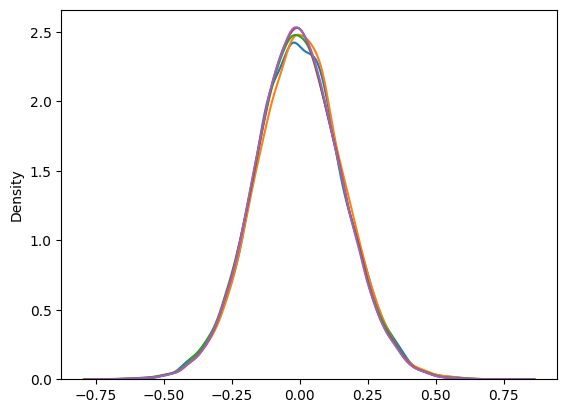

In [9]:
sns.kdeplot(training_anoms_concatted_5members.gmean)
sns.kdeplot(training_anoms_concatted_10members.gmean)
sns.kdeplot(training_anoms_concatted_15members.gmean)
sns.kdeplot(training_anoms_concatted_20members.gmean)
sns.kdeplot(training_anoms_concatted_25members.gmean)

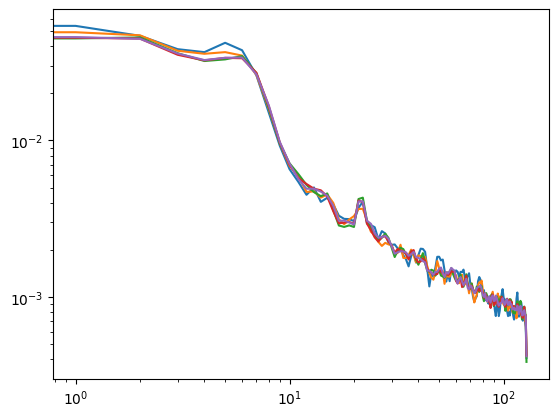

In [10]:
plt.loglog(welch_psd(training_anoms_concatted_5members.gmean))
plt.loglog(welch_psd(training_anoms_concatted_10members.gmean))
plt.loglog(welch_psd(training_anoms_concatted_15members.gmean))
plt.loglog(welch_psd(training_anoms_concatted_20members.gmean))
plt.loglog(welch_psd(training_anoms_concatted_25members.gmean))

In [11]:
for training_data, n_members in [(training_anoms_concatted_5members, 5),
                                 (training_anoms_concatted_10members, 10),
                                 (training_anoms_concatted_15members, 15),
                                 (training_anoms_concatted_20members, 20),
                                 (training_anoms_concatted_25members, 25)]:
    
    print('\n', n_members, '  training members \n')

    ### Calculate month-specific EOFs from training ensemble members
    for month in range(1,13):
        month_EOFs = calc_EOFs(training_data.groupby('month')[month].anoms, path=savepath,
                          filename = 'LENS2_'+str(n_members)+\
                          '_training_Tanom_EOFs_month='+str(month))
        print('month ' + str(month) + ' EOFs saved')

In [12]:
## Run emulator on each set of EOFs and save output

n_samples = 25   # number of InVERT ensemble members to generate
n_steps = 1980  # number of time steps (months) to generate per InVERT ensemble member 

optimal_lag = 12 # VAR model lag (months)
M = 120          # Number of initial time steps (months) to truncate for spin-up (aka 'burn-in' period)
LENS_esize = 50  # Size of LENS ensemble (number of members)

nmodes = 100

In [13]:
for n_training_members in [5, 10, 15, 20, 25]:
    
    print('\n', n_training_members, '  training members \n')
    
    month_da = xr.open_dataarray(savepath + 'month_da_' + str(n_training_members) + '_training_members.nc')
    
    solvers_bymonth = {}
    for month in range(1,13):
        solvers_bymonth[month] = calc_EOFs(0, path=savepath, 
                                           filename = 'LENS2_'+str(n_training_members)+\
                                           '_training_Tanom_EOFs_month='+str(month))

    ## Extract and save PCs, EOFs, and variance fractions from the EOF solver object
    eofs_dict = {}
    for month in range(1, 13):
        eofs_dict[month] = {}
        eofs_dict[month]['eofs'] = solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
        eofs_dict[month]['pcs'] = solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
        eofs_dict[month]['varfracs'] = solvers_bymonth[month].varianceFraction().sel(mode=slice(0, nmodes-1))

    ## Extract cos(lat) weights for later use
    weights = solvers_bymonth[1].getWeights()
    weights = xr.DataArray(weights, coords=[eofs_dict[1]['eofs']['lat'], 
                                            eofs_dict[1]['eofs']['lon']], 
                           dims=['lat', 'lon'])

    ### Compile DataArrays of PCs from the EOF solvers for each month
    pcs_unstacked = {}
    for month in range(1, 13):
        pcs_unstacked[month] = unstack_time(eofs_dict[month]['pcs'].drop('month'), 
                                            esize = n_training_members) 
    training_pcs_bymonth_unstacked = xr.Dataset(pcs_unstacked)
    training_pcs_bymonth = stack_time(training_pcs_bymonth_unstacked)

    # ## Extract each month's PC data array and adjust the 'time' values 
    month_pc_da_list = []
    for month in range(1, 13):
        training_pcs_da_month = training_pcs_bymonth[month].drop('ensemble')
        training_pcs_da_month['time'] = training_pcs_da_month.time * 12 + month - 1
        training_pcs_da_month = training_pcs_da_month.to_dataset(name='pcs')
        month_pc_da_list.append(training_pcs_da_month)

    training_pcs = xr.merge(month_pc_da_list).sortby('time')
    training_pcs['month'] = month_da.sel(time=slice(0,len(training_pcs['time'])))
    training_pcs = training_pcs.assign_coords({'month': training_pcs.month})
    training_pcs.to_netcdf(savepath + 'training_pcs_'+str(n_training_members)+'members.nc')

    ### Train 12 monthly VAR models 
    monthly_var_models = {}
    for target_month in range(1, 13): 
        input_features = []; output_targets = []
        for i in range(optimal_lag, len(training_pcs.time)):
            if training_pcs.month.values[i] == target_month:
                features = training_pcs.pcs.values[i - optimal_lag : i, :].flatten()
                input_features.append(features)
                targets = training_pcs.pcs.values[i, :]
                output_targets.append(targets)
        input_features = np.array(input_features); output_targets = np.array(output_targets)
        if len(input_features) > 0:
            X = np.hstack([np.ones((input_features.shape[0],1)), input_features])
            y = output_targets
            coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
            predicted_targets = X @ coefficients
            residuals = y - predicted_targets
            intercept = coefficients[0, :]
            lagged_coeffs = coefficients[1:, :]
            monthly_var_models[target_month] = {
                'intercept': intercept,
                'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
                'residuals': residuals} 

    ## Emulate PCs and save
    InVERT_pcs = emulate_pcs(training_pcs, monthly_var_models, n_training_members,
                             optimal_lag, n_samples, n_steps, nmodes, M, 
                             savepath+str(n_training_members)+'members_')

    ## Compute PCs * EOFs for each mode and divide by weights for every month. Save in dict.
    print('Multiplying PCs * EOFs and dividing by weights')
    products_by_month = {}
    for month in range(1, 13):
        print(month)
        products_by_month[month] = InVERT_pcs.groupby('month')[month] * eofs_dict[month]['eofs'] / weights

    ## Sum T anomalies over modes then merge
    print('Summing over modes')
    products_by_month_summed = {}
    for month in range(1, 13):
        print(month)
        products_by_month_summed[month] =  products_by_month[month].pcs.sum(dim='mode')

    ## Re-stack ensemble members over time dim and save in new dict
    print('Stacking ensemble members over time')
    Tanoms_bymonth = {}
    for month in range(1, 13):
        print(month)
        Tanoms_bymonth[month] = (stack_time(products_by_month_summed[month]))

    ## Extract each month's T anomaly data array and adjust the 'time' values so as to put them 
    ## back together in time order 
    print('Updating time indices')
    Tanom_da_list = []
    for month in range(1, 13):
        Tanoms_month = Tanoms_bymonth[month]
        Tanoms_month['time'] = Tanoms_month.time * 12 + month - 1
        Tanoms_month = Tanoms_month.to_dataset(name='T')
        Tanom_da_list.append(Tanoms_month)

    ## Concatenate over time dimension and then sort by time 
    print('Merging and sorting by time')
    InVERT_stacked = xr.concat(Tanom_da_list, dim='time').sortby('time')
    InVERT_stacked['gmean'] = areaweighted_mean(InVERT_stacked.T)
    
    InVERT_stacked.to_netcdf(savepath + 'InVERT_'+ \
                       str(n_training_members)+'_training_members_stacked.nc')

    ## Separate back into ensemble members
    InVERT_T = unstack_time(InVERT_stacked, esize=n_samples)

    print('Saving InVERT with ', nmodes, ' modes')
    InVERT_T.to_netcdf(savepath + 'InVERT_' +\
                       str(n_training_members)+'_training_members.nc')
    print('saved')


 5   training members 

Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Multiplying PCs * EOFs and dividing by weights
1
2
3
4
5
6
7
8
9
10
11
12
Summing over modes
1
2
3
4
5
6
7
8
9
10
11
12
Stacking ensemble members over time
1
2
3
4
5
6
7
8
9
10
11
12
Updating time indices
Merging and sorting by time
Saving InVERT with  100  modes
saved

 10   training members 

Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Multiplying PCs * EOFs and dividing by weights
1
2
3
4
5
6
7
8
9
10
11
12
Summing over modes
1
2
3
4
5
6
7
8
9
10
11
12
Stacking ensemble members over time
1
2
3
4
5
6
7
8
9
10
11
12
Updating time indices
Merging and sortin

In [15]:
InVERT_5members_stacked = xr.open_dataset(savepath + 'InVERT_5_training_members_stacked.nc')
InVERT_10members_stacked = xr.open_dataset(savepath + 'InVERT_10_training_members_stacked.nc')
InVERT_15members_stacked = xr.open_dataset(savepath + 'InVERT_15_training_members_stacked.nc')
InVERT_20members_stacked = xr.open_dataset(savepath + 'InVERT_20_training_members_stacked.nc')
InVERT_25members_stacked = xr.open_dataset(savepath + 'InVERT_25_training_members_stacked.nc')

<Axes: ylabel='Density'>

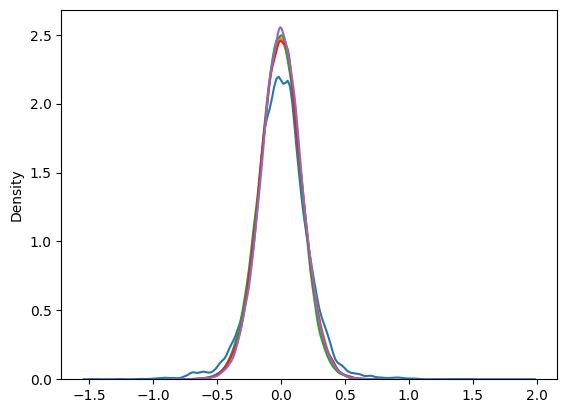

In [16]:
sns.kdeplot(InVERT_5members_stacked.gmean)
sns.kdeplot(InVERT_10members_stacked.gmean)
sns.kdeplot(InVERT_15members_stacked.gmean)
sns.kdeplot(InVERT_20members_stacked.gmean)
sns.kdeplot(InVERT_25members_stacked.gmean)

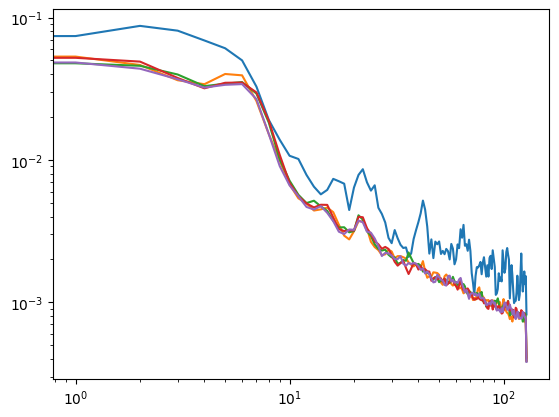

In [17]:
plt.loglog(welch_psd(InVERT_5members_stacked.gmean))
plt.loglog(welch_psd(InVERT_10members_stacked.gmean))
plt.loglog(welch_psd(InVERT_15members_stacked.gmean))
plt.loglog(welch_psd(InVERT_20members_stacked.gmean))
plt.loglog(welch_psd(InVERT_25members_stacked.gmean))

In [18]:
InVERT_5members = xr.open_dataset(savepath + 'InVERT_5_training_members.nc')
InVERT_10members = xr.open_dataset(savepath + 'InVERT_10_training_members.nc')
InVERT_15members = xr.open_dataset(savepath + 'InVERT_15_training_members.nc')
InVERT_20members = xr.open_dataset(savepath + 'InVERT_20_training_members.nc')
InVERT_25members = xr.open_dataset(savepath + 'InVERT_25_training_members.nc')

In [19]:
T_unstacked = xr.open_dataset(savepath + 'LENS2_Tanoms_25_testing_members.nc')
T_unstacked['time'] = np.arange(0, len(T_unstacked.time))
T_unstacked

<xarray.Dataset> Size: 4GB
Dimensions:   (time: 1980, lon: 192, lat: 96, ensemble: 25)
Coordinates:
  * time      (time) int64 16kB 0 1 2 3 4 5 6 ... 1974 1975 1976 1977 1978 1979
  * lon       (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat       (lat) float64 768B -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * ensemble  (ensemble) int64 200B 12 30 36 31 19 34 35 ... 16 41 4 27 22 2 45
Data variables:
    anoms     (ensemble, time, lat, lon) float32 4GB ...
    gmean     (ensemble, time) float64 396kB ...

In [20]:
Tanoms_lens = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')
Tanoms_lens

<xarray.Dataset> Size: 4GB
Dimensions:  (lon: 192, lat: 96, time: 49500)
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * time     (time) int64 396kB 0 1 2 3 4 5 ... 49495 49496 49497 49498 49499
    month    (time) int64 396kB ...
Data variables:
    anoms    (time, lat, lon) float32 4GB ...
    gmean    (time) float64 396kB ...

In [21]:
## Convert longitude
InVERT5_converted_lon = convert_lon(InVERT_5members, 'lon')
InVERT10_converted_lon = convert_lon(InVERT_10members, 'lon')
InVERT15_converted_lon = convert_lon(InVERT_15members, 'lon')
InVERT20_converted_lon = convert_lon(InVERT_20members, 'lon')
InVERT25_converted_lon = convert_lon(InVERT_25members, 'lon')

T_unstacked_converted_lon = convert_lon(T_unstacked, 'lon')

In [22]:
month_da_25members = xr.open_dataarray(savepath + 'month_da_25_training_members.nc')

T_unstacked_converted_lon = T_unstacked_converted_lon.assign_coords({'month': month_da_25members})
T_unstacked_converted_lon

<xarray.Dataset> Size: 4GB
Dimensions:   (time: 1980, lat: 96, ensemble: 25, lon: 192)
Coordinates:
  * time      (time) int64 16kB 0 1 2 3 4 5 6 ... 1974 1975 1976 1977 1978 1979
  * lat       (lat) float64 768B -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * ensemble  (ensemble) int64 200B 12 30 36 31 19 34 35 ... 16 41 4 27 22 2 45
  * lon       (lon) float64 2kB -180.0 -178.1 -176.2 ... 174.4 176.2 178.1
    month     (time) int64 16kB ...
Data variables:
    anoms     (ensemble, time, lat, lon) float32 4GB ...
    gmean     (ensemble, time) float64 396kB ...

####  Compare results for InVERT with 5, 10, 15, 20, and 25 training members relative to LENS2 testing ensemble

 - Local monthly stds 
 - PDFs of differences in gridcell standard deviations 

In [23]:
## Calculate ensemble mean standard deviations of T anomalies by month

LENS_emean_monthly_stds = T_unstacked_converted_lon.anoms.groupby('month').std('time').mean('ensemble')

In [24]:
InVERT5_emean_monthly_stds = InVERT5_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT10_emean_monthly_stds = InVERT10_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT15_emean_monthly_stds = InVERT15_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT20_emean_monthly_stds = InVERT20_converted_lon.T.groupby('month').std('time').mean('ensemble')
InVERT25_emean_monthly_stds = InVERT25_converted_lon.T.groupby('month').std('time').mean('ensemble')

In [25]:
LENS_estd_monthly_stds = T_unstacked_converted_lon.anoms.groupby('month').std('time').std('ensemble')

In [26]:
InVERT5_estd_monthly_stds = InVERT5_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT10_estd_monthly_stds = InVERT10_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT15_estd_monthly_stds = InVERT15_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT20_estd_monthly_stds = InVERT20_converted_lon.T.groupby('month').std('time').std('ensemble')
InVERT25_estd_monthly_stds = InVERT25_converted_lon.T.groupby('month').std('time').std('ensemble')

In [27]:
def plot_local_monthly_T_stds(LENS_emean_monthly_stds, InVERT1_emean_monthly_stds,
                              InVERT2_emean_monthly_stds, InVERT3_emean_monthly_stds, 
                              InVERT4_emean_monthly_stds, InVERT5_emean_monthly_stds,
                              LENS_estd_monthly_stds, InVERT1_estd_monthly_stds,
                              InVERT2_estd_monthly_stds, InVERT3_estd_monthly_stds,
                              InVERT4_estd_monthly_stds, InVERT5_estd_monthly_stds,
                              names, locations_lat_lon,
                              ylim=3, markersize=6, capsize=4, elinewidth=1.5, 
                              markeredgewidth=1.5,):

    n_locations = len(locations_lat_lon)
    if n_locations != 4:
        print("Please provide exactly four locations.")
        return

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), squeeze=False) # 2x2 grid
    axes = axes.flatten()
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']

    for i, (lat, lon, location) in enumerate(locations_lat_lon):
        ax = axes[i] # Get the current subplot axis

        invert1_emean_local = InVERT1_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert2_emean_local = InVERT2_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert3_emean_local = InVERT3_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert4_emean_local = InVERT4_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert5_emean_local = InVERT5_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        lens_emean_local = LENS_emean_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        
        invert1_estd_local = InVERT1_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert2_estd_local = InVERT2_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert3_estd_local = InVERT3_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert4_estd_local = InVERT4_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        invert5_estd_local = InVERT5_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')
        lens_estd_local = LENS_estd_monthly_stds.sel(lat=lat, lon=lon, method='nearest')

        lat_selected = np.round(invert1_emean_local.lat.values, 2)
        lon_selected = np.round(invert1_emean_local.lon.values, 2)

        print(f"{location}: {invert1_emean_local.lat.values}, {invert1_emean_local.lon.values}")

        if lat_selected >= 0: NS_hemisphere = 'N'
        else: NS_hemisphere = 'S'
        if lon_selected >= 0: EW_hemisphere = 'E'
        else: EW_hemisphere = 'W'
        
        ## LENS
        # Plot error bars with desired color
        ax.errorbar(np.arange(1, 13), lens_emean_local, yerr=lens_estd_local,
                    fmt='none', markersize=markersize, capsize=capsize, color='black', #label='LENS2',
                    ecolor='black', elinewidth=elinewidth,
                    markeredgewidth=markeredgewidth)  

        ax.plot(np.arange(1, 13), lens_emean_local, 'o', markersize=markersize, color='black',  # Plot markers with desired color
                 markerfacecolor='black', markeredgecolor='black', label='LENS2')  # Set marker properties

        ## InVERT
        # Plot markers separately with unfilled style
        for name, invert_emean_local in enumerate([invert1_emean_local, invert2_emean_local, 
                                                   invert3_emean_local, invert4_emean_local, 
                                                   invert5_emean_local]):
            ax.plot(np.arange(1.1, 13.1), invert_emean_local, 'x', markersize=markersize, label=names[name]) 
            
        ax.set_ylim(0,ylim[i]); ax.set_xlim(0.5,12.5)
        ax.set_xlabel('month', fontsize=axislabelfontsize)
        ax.set_xticks([2,4,6,8,10,12])
        ax.set_xticklabels(['2', '4', '6', '8', '10', '12'], fontsize=tickfontsize)
        
        if ylim[i] == 2:
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['0', '1', '2'])
        if ylim[i] == 3:
            ax.set_yticks([0,1,2,3])
            ax.set_yticklabels(['0', '1', '2', '3'])
        ax.set_title(location, fontsize=titlefontsize)
        if i == 0: # Add legend only to the top-left subplot
            ax.legend(fontsize=legendfontsize)

        ax.set_ylabel('standard deviation [K]', fontsize=axislabelfontsize)
        ax.text(-0.05, 1.1, subplot_labels[i], transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left', zorder=10)
        
    plt.suptitle('Local T anomaly standard deviations by month', fontsize=26)
    plt.tight_layout()

    fig.savefig(savepath + 'Figure_S10_local_monthly_stds.png')
    fig.savefig(savepath + 'Figure_S10_local_monthly_stds.pdf')

New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


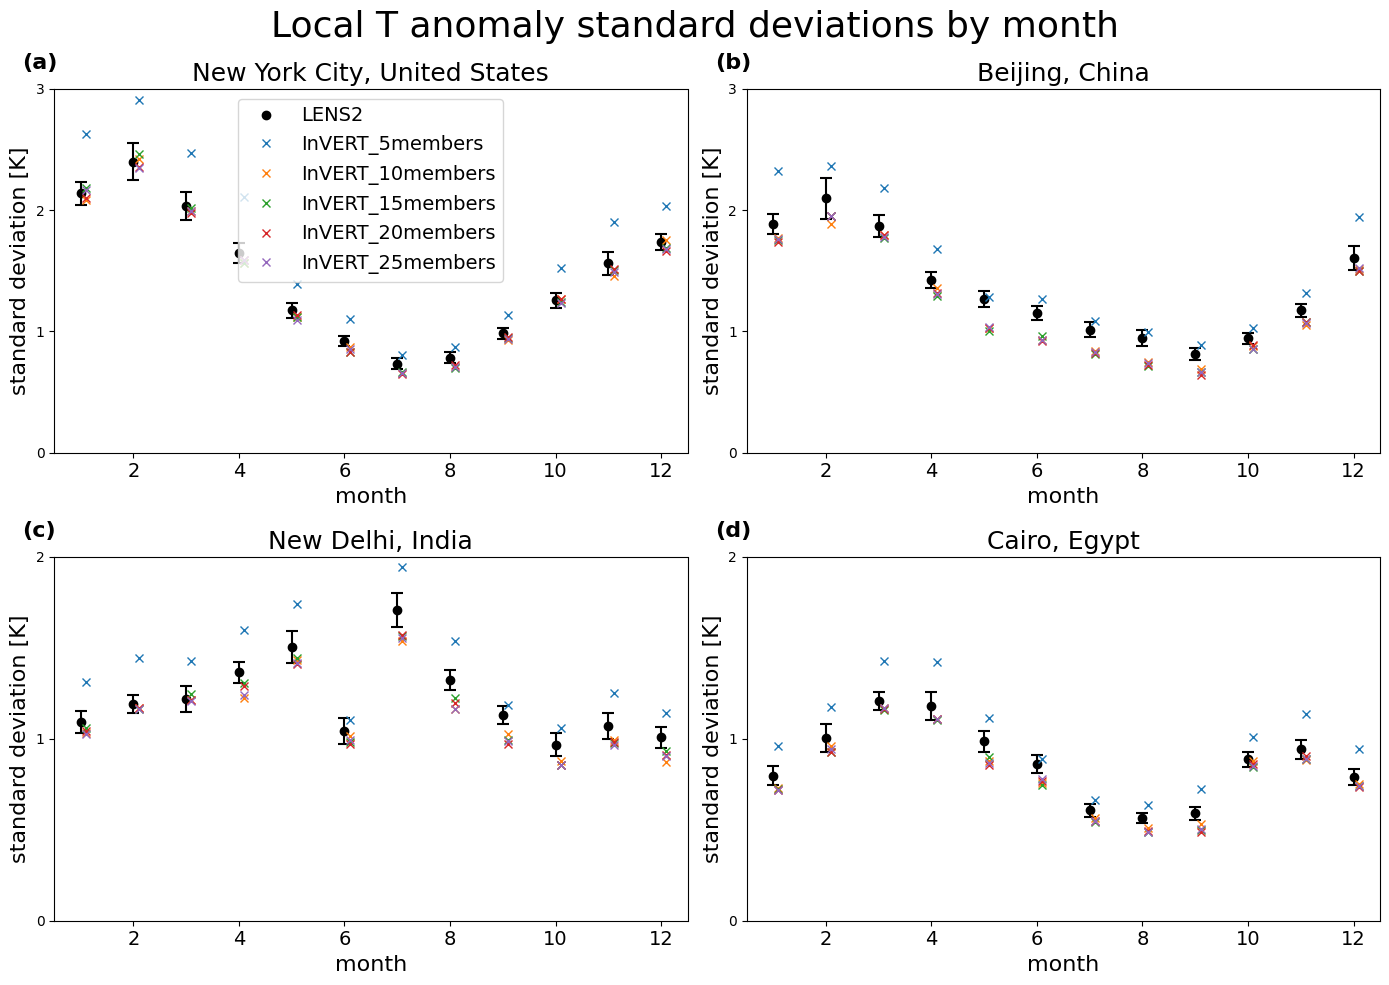

In [29]:
locations_lat_lon = [(40.7, -74, 'New York City, United States'),
                     (39.9, 116.4, 'Beijing, China'),
                     (28.7, 77.2, 'New Delhi, India'),
                     (30.05, 31.23, 'Cairo, Egypt' )]

plot_local_monthly_T_stds(LENS_emean_monthly_stds, InVERT5_emean_monthly_stds,
                          InVERT10_emean_monthly_stds, InVERT15_emean_monthly_stds,
                          InVERT20_emean_monthly_stds, InVERT25_emean_monthly_stds,
                          
                          LENS_estd_monthly_stds, InVERT5_estd_monthly_stds,
                          InVERT10_estd_monthly_stds, InVERT15_estd_monthly_stds,
                          InVERT20_estd_monthly_stds, InVERT25_estd_monthly_stds, 
                              
                          ['InVERT_5members', 'InVERT_10members', 
                           'InVERT_15members', 'InVERT_20members', 'InVERT_25members'],
                          
                          locations_lat_lon, ylim=[3,3,2,2])

In [30]:
## Compute gridcell standard deviations over time dimension

std_invert5 = InVERT_5members_stacked.T.std('time')
std_invert10 = InVERT_10members_stacked.T.std('time')
std_invert15 = InVERT_15members_stacked.T.std('time')
std_invert20 = InVERT_20members_stacked.T.std('time')
std_invert25 = InVERT_25members_stacked.T.std('time')

std_lens = Tanoms_lens.anoms.std('time')

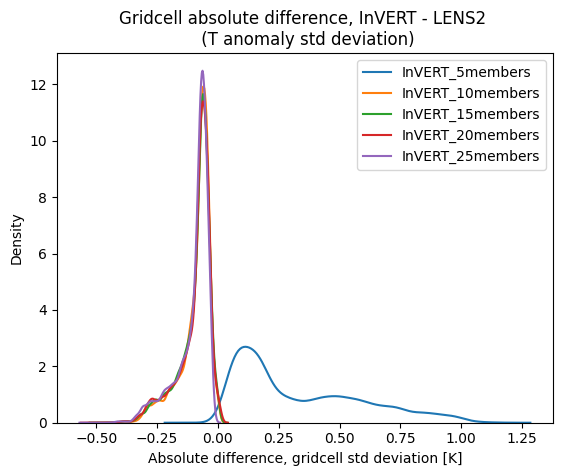

In [31]:
invert5_std_abs_diff = ((std_invert5 - std_lens).values).flatten()
invert10_std_abs_diff = ((std_invert10 - std_lens).values).flatten()
invert15_std_abs_diff = ((std_invert15 - std_lens).values).flatten()
invert20_std_abs_diff = ((std_invert20 - std_lens).values).flatten()
invert25_std_abs_diff = ((std_invert25 - std_lens).values).flatten()

sns.kdeplot(invert5_std_abs_diff, label='InVERT_5members')
sns.kdeplot(invert10_std_abs_diff, label='InVERT_10members')
sns.kdeplot(invert15_std_abs_diff, label='InVERT_15members')
sns.kdeplot(invert20_std_abs_diff, label='InVERT_20members')
sns.kdeplot(invert25_std_abs_diff, label='InVERT_25members')

plt.legend()
plt.xlabel('Absolute difference, gridcell std deviation [K]')
plt.title('Gridcell absolute difference, InVERT - LENS2 \n (T anomaly std deviation)', fontsize=12)

plt.savefig(savepath + 'Figure_S10_std_absolute_diff.png')
plt.savefig(savepath + 'Figure_S10_std_absolute_diff.pdf')

In [32]:
invert5_std_pct_diff = ((std_invert5 - std_lens)/std_lens*100).values.flatten()
invert10_std_pct_diff = ((std_invert10 - std_lens)/std_lens*100).values.flatten()
invert15_std_pct_diff = ((std_invert15 - std_lens)/std_lens*100).values.flatten()
invert20_std_pct_diff = ((std_invert20 - std_lens)/std_lens*100).values.flatten()
invert25_std_pct_diff = ((std_invert25 - std_lens)/std_lens*100).values.flatten()

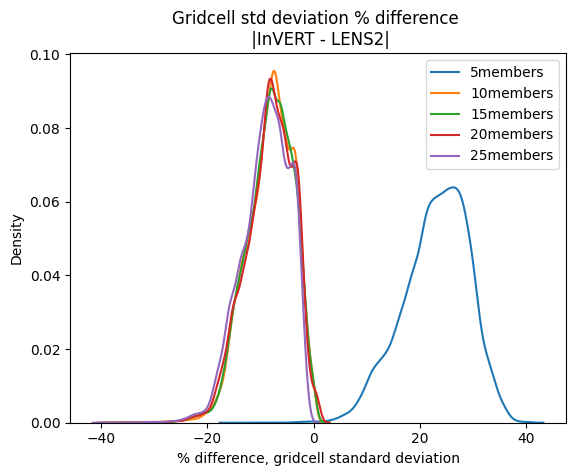

In [33]:
sns.kdeplot(invert5_std_pct_diff, label='5members')
sns.kdeplot(invert10_std_pct_diff, label='10members')
sns.kdeplot(invert15_std_pct_diff, label='15members')
sns.kdeplot(invert20_std_pct_diff, label='20members')
sns.kdeplot(invert25_std_pct_diff, label='25members')

plt.xlabel('% difference, gridcell standard deviation')

plt.legend()

plt.title('Gridcell std deviation % difference \n |InVERT - LENS2|')

plt.savefig(savepath + 'Figure_S10_std_percent_diff.png')
plt.savefig(savepath + 'Figure_S10_std_percent_diff.pdf')